#### Keyword Spotting

In [1]:
import os

# Set the correct dataset path
dataset_path = r"C:\Users\admin\Desktop\COLLEGE\SEM 6\Speech Processing\PROJECT\datasets\speech_commands_v0_extracted"

# Function to load the test and validation file lists
def load_split_list(file_name):
    file_path = os.path.join(dataset_path, file_name + ".txt")  # Ensure .txt extension

    # Check if file exists before opening
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    # Read file content
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Load test and validation lists
test_list = load_split_list("testing_list")  
val_list = load_split_list("validation_list")  

# Get all available keyword directories (excluding extra files)
keyword_dirs = [d for d in os.listdir(dataset_path) 
                if os.path.isdir(os.path.join(dataset_path, d))]

# Print results
print(f"Keywords Found: {keyword_dirs}")
print(f"Total Test Samples: {len(test_list)}")
print(f"Total Validation Samples: {len(val_list)}")

Keywords Found: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']
Total Test Samples: 11005
Total Validation Samples: 9981


In [50]:
import numpy as np

# Load labels
labels = np.load("speech_trigger_labels_v3.npy")

# Count the number of samples per class
unique_classes, counts = np.unique(labels, return_counts=True)

# Display count of samples per keyword
print("Dataset Label Distribution:", dict(zip(unique_classes, counts)))


Dataset Label Distribution: {0: 4044, 1: 3941, 2: 3880, 3: 3872, 4: 3801, 5: 3778}


In [3]:
import IPython.display as ipd

yes_sample = os.path.join(dataset_path, "yes", "00f0204f_nohash_0.wav")

# Check if the file exists
if not os.path.exists(yes_sample):
    raise FileNotFoundError(f"File not found: {yes_sample}")

# Play the audio file
print(f"Playing sample: {os.path.basename(yes_sample)}")
ipd.display(ipd.Audio(yes_sample))

Playing sample: 00f0204f_nohash_0.wav


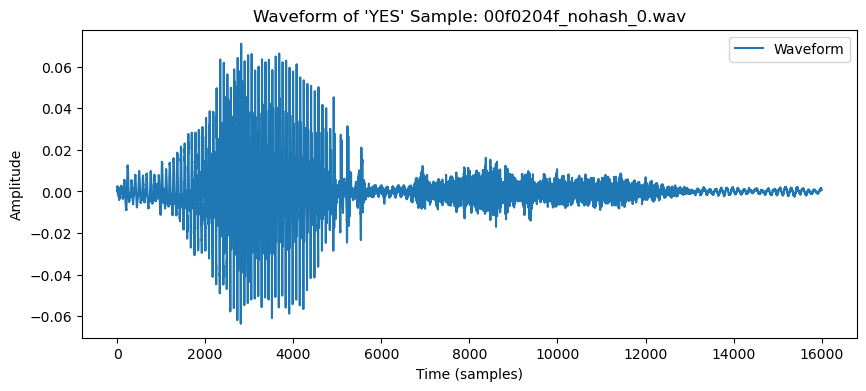

In [5]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# Load audio file using soundfile
waveform, sample_rate = sf.read(yes_sample)

# Convert stereo to mono if needed
if len(waveform.shape) > 1:
    waveform = np.mean(waveform, axis=1)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform, label="Waveform")
plt.title(f"Waveform of 'YES' Sample: {os.path.basename(yes_sample)}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


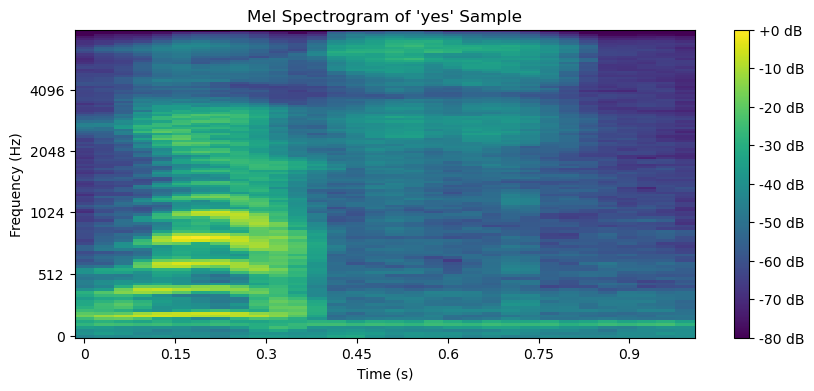

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file
waveform, sample_rate = librosa.load(yes_sample, sr=None)

# Compute Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000)

# Convert to log scale (better for visualization)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis="time", y_axis="mel", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram of 'yes' Sample")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [77]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 18652
Testing samples: 4664


---

Start

### Modularized function for feature extraction:

In [2]:
import librosa
import numpy as np
import os

# Feature extraction parameters
SAMPLE_RATE = 16000
N_MFCC = 20
N_MELS = 128
FMAX = 8000
DURATION = 1.0  # Ensure all audio is 1 second long

def extract_features(file_path):
    """
    Extracts multiple audio features from a given audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        np.array: Extracted feature vector.
    """
    try:
        waveform, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(waveform) < SAMPLE_RATE:  # Pad if shorter than 1 sec
            waveform = np.pad(waveform, (0, SAMPLE_RATE - len(waveform)), mode="constant")

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # Extract Delta & Delta-Delta MFCCs
        delta_mfccs = librosa.feature.delta(mfccs)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)

        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        # Extract Chroma Features
        chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Extract Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

        # Extract Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=waveform)
        zcr_mean = np.mean(zcr)

        # Extract Log-Mel Spectrogram Features
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=N_MELS, fmax=FMAX)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_mean = np.mean(mel_spectrogram_db, axis=1)
        mel_std = np.std(mel_spectrogram_db, axis=1)

        # Combine all extracted features
        combined_features = np.concatenate((
            mfccs_mean, mfccs_std,  # MFCC Mean & Std
            delta_mfccs_mean, delta_mfccs_std,  # Delta MFCCs
            delta2_mfccs_mean, delta2_mfccs_std,  # Delta-Delta MFCCs
            chroma_mean, spectral_contrast_mean,  # Chroma & Spectral Contrast
            [zcr_mean],  # Zero-Crossing Rate
            mel_mean, mel_std  # Log-Mel Spectrogram Mean & Std
        ))

        return combined_features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


1. Extract features for the dataset (Training)

In [3]:
# Lists to store features and labels
features = []
labels = []

# Define relevant keywords for triggering
trigger_keywords = ["yes", "no", "go", "stop", "left", "right"]

dataset_path = r"C:\Users\admin\Desktop\COLLEGE\SEM 6\Speech Processing\PROJECT\datasets\speech_commands_v0_extracted"

for label, keyword in enumerate(trigger_keywords):
    keyword_path = os.path.join(dataset_path, keyword)

    if not os.path.exists(keyword_path):
        print(f"Warning: Keyword '{keyword}' not found in dataset.")
        continue

    for file_name in os.listdir(keyword_path):
        file_path = os.path.join(keyword_path, file_name)
        feature_vector = extract_features(file_path)
        if feature_vector is not None:
            features.append(feature_vector)
            labels.append(label)

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Save extracted features
np.save("speech_trigger_features_v3.npy", features)
np.save("speech_trigger_labels_v3.npy", labels)

print(f"Feature extraction completed! Extracted {features.shape[0]} samples with {features.shape[1]} features each.")

c:\Users\admin\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed! Extracted 23316 samples with 396 features each.


Model Training

In [68]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the extracted features and labels
features = np.load("speech_trigger_features_v3.npy")
labels = np.load("speech_trigger_labels_v3.npy")

# Normalize the features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the trained model
model.save("speech_trigger_model.h5")
print("Model saved successfully!")

Epoch 1/50


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5255 - loss: 1.2320 - val_accuracy: 0.7663 - val_loss: 0.6517
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7463 - loss: 0.7056 - val_accuracy: 0.8000 - val_loss: 0.5569
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7734 - loss: 0.6273 - val_accuracy: 0.8060 - val_loss: 0.5233
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7872 - loss: 0.5826 - val_accuracy: 0.8233 - val_loss: 0.5015
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8082 - loss: 0.5311 - val_accuracy: 0.8272 - val_loss: 0.4917
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8126 - loss: 0.5218 - val_accuracy: 0.8328 - val_loss: 0.4629
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8187 - loss: 0.4988 - val_accuracy: 0.8355 - val_loss: 0.4663
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8250 - loss: 0.4754 - val_accuracy: 0.8388 - val_

Test Accuracy: 85.76%
Model saved successfully!


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Accuracy for class 0 (0): 94.44%
Accuracy for class 1 (0): 81.85%
Accuracy for class 2 (0): 80.80%
Accuracy for class 3 (0): 90.58%
Accuracy for class 4 (0): 80.92%
Accuracy for class 5 (0): 85.58%


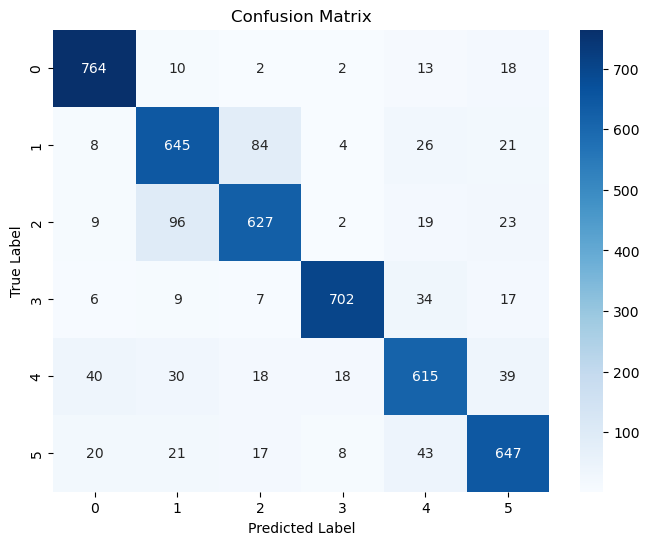


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       809
           1       0.80      0.82      0.81       788
           2       0.83      0.81      0.82       776
           3       0.95      0.91      0.93       775
           4       0.82      0.81      0.81       760
           5       0.85      0.86      0.85       756

    accuracy                           0.86      4664
   macro avg       0.86      0.86      0.86      4664
weighted avg       0.86      0.86      0.86      4664



In [70]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
model = tf.keras.models.load_model("speech_trigger_model.h5")

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute per-class accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display accuracy for each class
for i, acc in enumerate(class_accuracies):
    print(f"Accuracy for class {i} ({labels[i]}): {acc:.2%}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


#### Test with new sample

In [1]:
# Load the trained model
from tensorflow.keras.models import load_model

model = load_model("speech_trigger_model.h5")

# Extract features from a new sample
test_sample_path = "0a2b400e_nohash_0.wav"  # Replace with the actual path
test_features = extract_features(test_sample_path)

if test_features is not None:
    test_features = np.expand_dims(test_features, axis=0)  # Reshape for model input
    prediction = model.predict(test_features)
    predicted_label = np.argmax(prediction)
    
    print(f"Predicted Label: {trigger_keywords[predicted_label]}")

NameError: name 'extract_features' is not defined

In [76]:
from tensorflow.keras.models import load_model
import cv2

model = load_model("speech_trigger_model.h5")

test_sample_path = "yes.wav"  # Replace with actual path
test_features = extract_features(test_sample_path)

def trigger_camera():
    print("Triggering camera...")
    cam = cv2.VideoCapture(0)  # Open the webcam (0 for default camera)
    ret, frame = cam.read()
    if ret:
        cv2.imwrite("captured_image.jpg", frame)  # Save the captured image
        print("Image captured successfully.")
    else:
        print("Failed to capture image.")
    cam.release()
    cv2.destroyAllWindows()


if test_features is not None:
    test_features = np.expand_dims(test_features, axis=0)  # Reshape for model input
    prediction = model.predict(test_features)
    predicted_label = np.argmax(prediction)
    predicted_keyword = trigger_keywords[predicted_label]

    print(f"Predicted Label: {predicted_keyword}")

    # Trigger camera if keyword matches
    if predicted_keyword in trigger_keywords:
        trigger_camera()
    else:
        print("No trigger keyword detected.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label: yes
Triggering camera...
Image captured successfully.


Done

---

Without chroma

In [51]:
import librosa
import numpy as np
import os

# Feature extraction parameters
SAMPLE_RATE = 16000
N_MFCC = 20
N_MELS = 128
FMAX = 8000
DURATION = 1.0  # Ensure all audio is 1 second long

def extract_features(file_path):
    """
    Extracts selected audio features from a given audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        np.array: Extracted feature vector.
    """
    try:
        waveform, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(waveform) < SAMPLE_RATE:  # Pad if shorter than 1 sec
            waveform = np.pad(waveform, (0, SAMPLE_RATE - len(waveform)), mode="constant")

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)

        # Extract Delta & Delta-Delta MFCCs
        delta_mfccs = librosa.feature.delta(mfccs)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)

        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        # Extract Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=waveform)
        zcr_mean = np.mean(zcr)

        # Extract Log-Mel Spectrogram Features
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=N_MELS, fmax=FMAX)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_mean = np.mean(mel_spectrogram_db, axis=1)
        mel_std = np.std(mel_spectrogram_db, axis=1)

        # Combine all extracted features (excluding chroma and spectral contrast)
        combined_features = np.concatenate((
            mfccs_mean, mfccs_std,  # MFCC Mean & Std
            delta_mfccs_mean, delta_mfccs_std,  # Delta MFCCs
            delta2_mfccs_mean, delta2_mfccs_std,  # Delta-Delta MFCCs
            [zcr_mean],  # Zero-Crossing Rate
            mel_mean, mel_std  # Log-Mel Spectrogram Mean & Std
        ))

        return combined_features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [52]:
# Lists to store features and labels
features = []
labels = []

# Define relevant keywords for triggering
trigger_keywords = ["yes", "no", "go", "stop", "left", "right"]

dataset_path = r"C:\Users\admin\Desktop\COLLEGE\SEM 6\Speech Processing\PROJECT\datasets\speech_commands_v0_extracted"

for label, keyword in enumerate(trigger_keywords):
    keyword_path = os.path.join(dataset_path, keyword)

    if not os.path.exists(keyword_path):
        print(f"Warning: Keyword '{keyword}' not found in dataset.")
        continue

    for file_name in os.listdir(keyword_path):
        file_path = os.path.join(keyword_path, file_name)
        feature_vector = extract_features(file_path)
        if feature_vector is not None:
            features.append(feature_vector)
            labels.append(label)

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Save extracted features
np.save("speech_trigger_features_v4.npy", features)
np.save("speech_trigger_labels_v4.npy", labels)

print(f"Feature extraction completed! Extracted {features.shape[0]} samples with {features.shape[1]} features each.")


Feature extraction completed! Extracted 23316 samples with 377 features each.


In [53]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the extracted features and labels
features = np.load("speech_trigger_features_v4.npy")
labels = np.load("speech_trigger_labels_v4.npy")

# Normalize the features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5093 - loss: 1.2783 - val_accuracy: 0.7672 - val_loss: 0.6676
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7412 - loss: 0.7243 - val_accuracy: 0.7800 - val_loss: 0.6069
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7652 - loss: 0.6532 - val_accuracy: 0.7901 - val_loss: 0.5710
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7823 - loss: 0.6084 - val_accuracy: 0.8075 - val_loss: 0.5421
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7982 - loss: 0.5593 - val_accuracy: 0.8143 - val_loss: 0.5269
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8083 - loss: 0.5308 - val_accuracy: 0.8231 - val_loss: 0.4972
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8092 - loss: 0.5222 - val_accuracy: 0.8298 - val_loss: 0.4917
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8218 - loss: 0.4937 - val_accuracy: 0.8332 - val_

In [54]:
# Save the trained model
model.save("speech_trigger_model_1.h5")
print("Model saved successfully!")

Model saved successfully!


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step


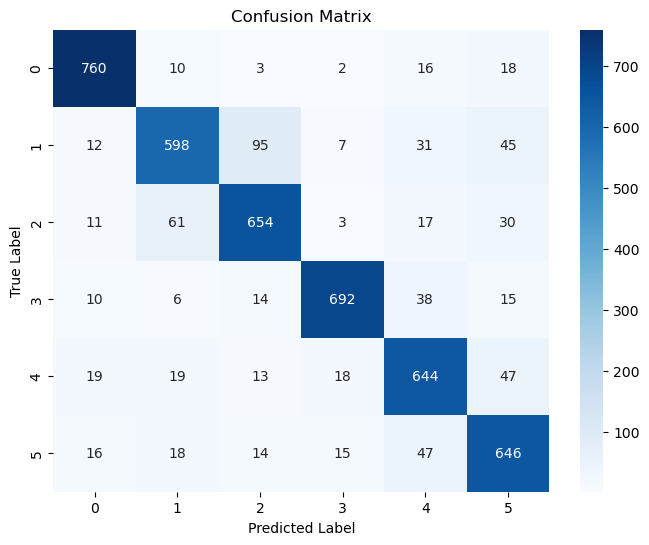

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       809
           1       0.84      0.76      0.80       788
           2       0.82      0.84      0.83       776
           3       0.94      0.89      0.92       775
           4       0.81      0.85      0.83       760
           5       0.81      0.85      0.83       756

    accuracy                           0.86      4664
   macro avg       0.86      0.86      0.86      4664
weighted avg       0.86      0.86      0.86      4664



In [55]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the trained model
model = tf.keras.models.load_model("speech_trigger_model_1.h5")

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for more insights
print("Classification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# Load the trained model
from tensorflow.keras.models import load_model

model = load_model("speech_trigger_model_1.h5")

# Extract features from a new sample
test_sample_path = "0a2b400e_nohash_0.wav"
test_features = extract_features(test_sample_path)

if test_features is not None:
    test_features = np.expand_dims(test_features, axis=0)  # Reshape for model input
    prediction = model.predict(test_features)
    predicted_label = np.argmax(prediction)
    
    print(f"Predicted Label: {trigger_keywords[predicted_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Label: stop


In [58]:
from tensorflow.keras.models import load_model
import cv2

model = load_model("speech_trigger_model_1.h5")

test_sample_path = "yes.wav"  # Replace with actual path
test_features = extract_features(test_sample_path)

def trigger_camera():
    print("Triggering camera...")
    cam = cv2.VideoCapture(0)  # Open the webcam (0 for default camera)
    ret, frame = cam.read()
    if ret:
        cv2.imwrite("captured_image.jpg", frame)  # Save the captured image
        print("Image captured successfully.")
    else:
        print("Failed to capture image.")
    cam.release()
    cv2.destroyAllWindows()


if test_features is not None:
    test_features = np.expand_dims(test_features, axis=0)  # Reshape for model input
    prediction = model.predict(test_features)
    predicted_label = np.argmax(prediction)
    predicted_keyword = trigger_keywords[predicted_label]

    print(f"Predicted Label: {predicted_keyword}")

    # Trigger camera if keyword matches
    if predicted_keyword in trigger_keywords:
        trigger_camera()
    else:
        print("No trigger keyword detected.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label: yes
Triggering camera...
Image captured successfully.


Trying to improve accuracy with different model

New MLP

In [40]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Load the extracted features and labels
features = np.load("speech_trigger_features_v3.npy")  # Shape: (num_samples, num_features)
labels = np.load("speech_trigger_labels_v3.npy")

# Normalize the features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# ✅ Corrected Model (MLP-based)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5099 - loss: 1.3468 - val_accuracy: 0.7494 - val_loss: 0.6655
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7191 - loss: 0.7599 - val_accuracy: 0.8040 - val_loss: 0.5550
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7654 - loss: 0.6523 - val_accuracy: 0.8130 - val_loss: 0.5251
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7894 - loss: 0.5953 - val_accuracy: 0.8186 - val_loss: 0.5069
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.5599 - val_accuracy: 0.8298 - val_loss: 0.4792
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8104 - loss: 0.5350 - val_accuracy: 0.8302 - val_loss: 0.4784
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8094 - loss: 0.5258 - val_accuracy: 0.8325 - val_loss: 0.4596
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8144 - loss: 0.5123 - val_accuracy: 0.8450 - val_

CNN Arch with v3 features

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# Load and preprocess data
features = np.load("speech_trigger_features_v3.npy")
labels = np.load("speech_trigger_labels_v3.npy")

# Normalize features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Reshape for Conv1D (Add 1 channel)
features = features.reshape(features.shape[0], features.shape[1], 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GlobalAveragePooling1D(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3420 - loss: 1.5924 - val_accuracy: 0.4515 - val_loss: 1.3552
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4595 - loss: 1.3284 - val_accuracy: 0.5127 - val_loss: 1.2243
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5225 - loss: 1.2135 - val_accuracy: 0.5152 - val_loss: 1.2596
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5775 - loss: 1.0932 - val_accuracy: 0.5304 - val_loss: 1.2079
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6182 - loss: 0.9933 - val_accuracy: 0.5272 - val_loss: 1.2469
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6498 - loss: 0.9274 - val_accuracy: 0.5695 - val_loss: 1.1435
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6859 - loss: 0.8230 - val_accuracy: 0.5866 - val_loss: 1.0494
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7040 - loss: 0.7777 - val_accuracy: 0.51

CNN with v1 features

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# Load and preprocess data
features = np.load("speech_trigger_features.npy")
labels = np.load("speech_trigger_labels.npy")

# Normalize features
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Reshape for Conv1D (Add 1 channel)
features = features.reshape(features.shape[0], features.shape[1], 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GlobalAveragePooling1D(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/10


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2947 - loss: 1.7260 - val_accuracy: 0.4318 - val_loss: 1.4153
Epoch 2/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4730 - loss: 1.3473 - val_accuracy: 0.4919 - val_loss: 1.2941
Epoch 3/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5184 - loss: 1.2363 - val_accuracy: 0.4666 - val_loss: 1.4152
Epoch 4/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5406 - loss: 1.1830 - val_accuracy: 0.5229 - val_loss: 1.2253
Epoch 5/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5740 - loss: 1.1176 - val_accuracy: 0.5279 - val_loss: 1.2227
Epoch 6/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5882 - loss: 1.0812 - val_accuracy: 0.5583 - val_loss: 1.1677
Epoch 7/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6039 - loss: 1.0395 - val_accuracy: 0.5437 - val_loss: 1.1729
Epoch 8/10
583/583 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6126 - loss: 1.0134 - val_accuracy: 0.5506 - val

LSTM

In [44]:
from tensorflow.keras.layers import LSTM

# Reshape features for LSTM (Time step format)
features = features.reshape(features.shape[0], features.shape[1], 1)

# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/5


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


583/583 ━━━━━━━━━━━━━━━━━━━━ 100s 168ms/step - accuracy: 0.3109 - loss: 1.5897 - val_accuracy: 0.4284 - val_loss: 1.4041
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 100s 172ms/step - accuracy: 0.3571 - loss: 1.5064 - val_accuracy: 0.3615 - val_loss: 1.4876
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 94s 162ms/step - accuracy: 0.3221 - loss: 1.5609 - val_accuracy: 0.3381 - val_loss: 1.5012
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - accuracy: 0.3387 - loss: 1.5334 - val_accuracy: 0.3656 - val_loss: 1.4914
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 94s 161ms/step - accuracy: 0.3974 - loss: 1.4542 - val_accuracy: 0.4503 - val_loss: 1.3245
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.4475 - loss: 1.3122
Test Accuracy: 45.03%


---

With a different arch, Feedforward Deep Neural Network

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

# Load extracted features
X = np.load("speech_trigger_features_v3.npy")
y = np.load("speech_trigger_labels_v3.npy")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# Model Architecture
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.2),
    
    layers.Dense(6, activation="softmax")  # 6 classes (yes, no, go, stop, left, right)
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5392 - loss: 1.2162 - val_accuracy: 0.4719 - val_loss: 1.2261
Epoch 2/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7164 - loss: 0.7751 - val_accuracy: 0.4951 - val_loss: 2.0897
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7392 - loss: 0.7164 - val_accuracy: 0.3167 - val_loss: 2.9300
Epoch 4/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7610 - loss: 0.6794 - val_accuracy: 0.5669 - val_loss: 1.2222
Epoch 5/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7626 - loss: 0.6591 - val_accuracy: 0.6870 - val_loss: 0.8332
Epoch 6/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7733 - loss: 0.6230 - val_accuracy: 0.5420 - val_loss: 1.2260
Epoch 7/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7844 - loss: 0.6067 - val_accuracy: 0.5851 - val_loss: 1.1961
Epoch 8/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7850 - loss: 0.5867 - val_accuracy: 0.

#### Custom testing

In [ ]:
import numpy as np
import librosa
import tensorflow as tf

# Define constants (same as training)
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 128
FMAX = 8000
TRIGGER_KEYWORDS = ["yes", "no", "go", "stop", "left", "right"]  # Ensure these match training labels

# Load trained model
model = tf.keras.models.load_model("speech_trigger_model.h5")  # Change path if needed

# Function to extract features from a single audio file
def extract_features(file_path):
    try:
        # Load audio file
        waveform, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=N_MFCC)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Extract Mel Spectrogram features
        mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=N_MELS, fmax=FMAX)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_mean = np.mean(mel_spectrogram_db, axis=1)

        # Combine features
        combined_features = np.concatenate((mfccs_mean, mel_mean))

        # Normalize (same as training)
        combined_features = (combined_features - np.mean(combined_features)) / np.std(combined_features)

        # Reshape to match model input
        combined_features = combined_features.reshape(1, -1, 1)  # (1, features, 1)

        return combined_features

    except Exception as e:
        print(f"Error processing file: {e}")
        return None

# Function to predict keyword from a given .wav file
def predict_keyword(file_path):
    features = extract_features(file_path)
    if features is None:
        print("Error extracting features.")
        return

    # Get prediction
    prediction = model.predict(features)
    predicted_index = np.argmax(prediction)  # Get index of highest probability
    confidence = np.max(prediction)

    # Check confidence threshold
    if confidence > 0.5:  # Adjust threshold as needed
        print(f"Keyword Found: {TRIGGER_KEYWORDS[predicted_index]} (Confidence: {confidence:.2f})")
    else:
        print("No Keyword Found.")

# Test the model on a new .wav file
file_path = "test_audio.wav"  # Change to your test file path
predict_keyword(file_path)
